In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
df = pd.read_csv('Historical Product Demand.csv')

In [4]:
#Since the number of missing values are about 1%, I am taking an 'executive decision' of removing them. ;) 
df.dropna(axis=0, inplace=True) #remove all rows with na's.
df.reset_index(drop=True)
df.sort_values('Date')[10:20] #Some of the values have () in them.

,Product_Code,Warehouse,Product_Category,Date,Order_Demand
44795,Product_0965,Whse_A,Category_006,2011/11/18,1
44796,Product_0965,Whse_A,Category_006,2011/11/21,3
44797,Product_0965,Whse_A,Category_006,2011/11/21,5
44798,Product_0965,Whse_A,Category_006,2011/11/21,2
119561,Product_0980,Whse_A,Category_028,2011/11/21,100
107158,Product_0138,Whse_J,Category_007,2011/11/22,188
107159,Product_0138,Whse_J,Category_007,2011/11/22,1852
111727,Product_0982,Whse_A,Category_028,2011/11/22,3700
44102,Product_0980,Whse_A,Category_028,2011/11/23,1000
71915,Product_0980,Whse_A,Category_028,2011/11/23,200


In [5]:
#Target Feature - Order_Demand
#Removing () from the target feature.
df['Order_Demand'] = df['Order_Demand'].str.replace('(',"")
df['Order_Demand'] = df['Order_Demand'].str.replace(')',"")

#Next step is to change the data type.
df['Order_Demand'] = df['Order_Demand'].astype('int64')

C:\Users\junsuk\AppData\Local\Temp\ipykernel_15872\1192901098.py:3: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df['Order_Demand'] = df['Order_Demand'].str.replace('(',"")
C:\Users\junsuk\AppData\Local\Temp\ipykernel_15872\1192901098.py:4: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df['Order_Demand'] = df['Order_Demand'].str.replace(')',"")


In [10]:
# Convert to datetime dtype.
from datetime import datetime

df['Date'] = df['Date'].apply(lambda x: datetime.strptime(x, '%Y/%m/%d'))

In [25]:
df = df[(df['Date']>='2012-01-01') & (df['Date']<='2016-12-31')].sort_values('Date', ascending=True)
df_sum = df.groupby('Date')['Order_Demand'].sum().reset_index()
df_sum = df_sum.set_index('Date')
df_sum

,Order_Demand
Date,
2012-01-01,2
2012-01-02,680277
2012-01-03,1645257
2012-01-04,1295861
2012-01-05,8941774
...,...
2016-12-26,3628370
2016-12-27,1674226
2016-12-28,2740302


In [26]:

y = df_sum['Order_Demand'].resample('W').mean()
y_hat = df_sum['Order_Demand']

In [27]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import SimpleRNN
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Activation
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MSE
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler

In [19]:
def ts_train_test(all_data, time_steps): 
    """
    input:
     data: dataframe with dates and price data
    output:
     X_train, y_train: data from 2013/1/1-2018-12/31 
     X_test : data from 2019 - 
    time_steps: # of the input time steps 
    for_periods: # of the output time steps 
    """
    
    ts = all_data.filter(['price']).values
    #ts_test_len = len(ts_test)
    
    sc = MinMaxScaler()
    ts_scaled = sc.fit_transform(ts)
    ts_train_scaled = ts_scaled[0:1300,:]
    ts_train_len = len(ts_train_scaled)
    # create training data of s samples and t time steps 
    X_train = [] 
    y_train = [] 
    for i in range(time_steps, ts_train_len): 
        X_train.append(ts_train_scaled[i-time_steps:i,0])
        y_train.append(ts_train_scaled[i,0])
    X_train, y_train = np.array(X_train), np.array(y_train)
    
    # Reshapng X_train for efficient modelling 
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1],1))
    
    ts_test_scaled = ts_scaled[1300 - time_steps:,:]
    # Preparing to creat X_test 
    #inputs = pd.concat((all_data["price"][:1300], all_data["price"][1300:]), axis=0).values
    #print(inputs)
    #inputs = inputs[len(inputs)-len(ts_test) - time_steps:]
    #print(inputs)
    #inputs = inputs.reshape(-1,1)
    #print(inputs)
    #inputs = sc.transform(inputs)
    #print(inputs)
    
    X_test = []
    y_test = all_data.iloc[ts_train_len:,:]
    for i in range(time_steps, len(ts_test_scaled)):
        X_test.append(ts_test_scaled[i - time_steps : i, 0])
    
    X_test = np.array(X_test)
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1],1))
    
    return X_train, y_train, X_test, y_test, sc

In [20]:
def LSTM_model(X_train, y_train, X_test, sc):
    # create a model
    from keras.models import Sequential
    from keras.layers import Dense, SimpleRNN, GRU, LSTM
    from keras.optimizers import SGD
    
    # The LSTM architecture
    my_LSTM_model = Sequential()
    my_LSTM_model.add(LSTM(512, activation='relu',return_sequences=True, input_shape=(X_train.shape[1],1)))
    my_LSTM_model.add(LSTM(256, activation = 'relu',return_sequences=False))
    my_LSTM_model.add(Dense(128))
    my_LSTM_model.add(Dense(64))
    my_LSTM_model.add(Dense(32))
    my_LSTM_model.add(Dense(1))
    
    
    # Compiling 
    my_LSTM_model.compile(optimizer = "Adam",
                         loss = 'mean_squared_error', metrics=['accuracy','mape','mae'])
    
    # Fitting to the training set 
    my_LSTM_model.fit(X_train, y_train, epochs = 20, batch_size = 32, verbose = 1)
    
    LSTM_prediction = my_LSTM_model.predict(X_test)
    LSTM_prediction = sc.inverse_transform(LSTM_prediction)
    
    return my_LSTM_model, LSTM_prediction 

In [21]:
def actual_pred_plot(all_data,predictions):
    """
    Plot the actual vs predition
    """
    orderD = all_data.filter(['price'])
    train = orderD[:1300]
    valid = orderD[1300:]
    valid["Predictions"] = predictions
    #visualize the data
    plt.figure(figsize=(16, 8))
    plt.title("Forecast with Optimized LSTM Model")
    plt.xlabel("Time", fontsize=14)
    plt.ylabel("Order Demand", fontsize=14)
    plt.plot(all_data["date"][:1300], train["price"])
    plt.plot(all_data["date"][1300:], valid[["price", "Predictions"]])
    plt.legend(["Train", "Validation", "Predictions"], loc="upper right")
    plt.show()

In [28]:
import random
random.seed(123456)

In [29]:
df_sum_origin = df_sum.reset_index()
df_sum_origin.columns = ['date','price']
df_sum_origin

,date,price
0,2012-01-01,2
1,2012-01-02,680277
2,2012-01-03,1645257
3,2012-01-04,1295861
4,2012-01-05,8941774
...,...,...
1676,2016-12-26,3628370
1677,2016-12-27,1674226
1678,2016-12-28,2740302
1679,2016-12-29,530487


Epoch 1/20
40/40 [==============================] - 18s 387ms/step - loss: 0.0478 - accuracy: 0.0063 - mape: 1998517.0000 - mae: 0.1778
Epoch 2/20
40/40 [==============================] - 15s 387ms/step - loss: 0.0419 - accuracy: 0.0063 - mape: 2116130.2500 - mae: 0.1654
Epoch 3/20
40/40 [==============================] - 16s 392ms/step - loss: 0.0414 - accuracy: 0.0063 - mape: 2173319.2500 - mae: 0.1645
Epoch 4/20
40/40 [==============================] - 16s 401ms/step - loss: 0.0411 - accuracy: 0.0063 - mape: 2088834.2500 - mae: 0.1641
Epoch 5/20
40/40 [==============================] - 16s 391ms/step - loss: 0.0405 - accuracy: 0.0063 - mape: 2122300.0000 - mae: 0.1617
Epoch 6/20
40/40 [==============================] - 16s 390ms/step - loss: 0.0410 - accuracy: 0.0063 - mape: 2074788.8750 - mae: 0.1646
Epoch 7/20
40/40 [==============================] - 16s 391ms/step - loss: 0.0391 - accuracy: 0.0063 - mape: 1970402.3750 - mae: 0.1586
Epoch 8/20
40/40 [==============================

C:\Users\junsuk\AppData\Local\Temp\ipykernel_15872\1523316525.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid["Predictions"] = predictions


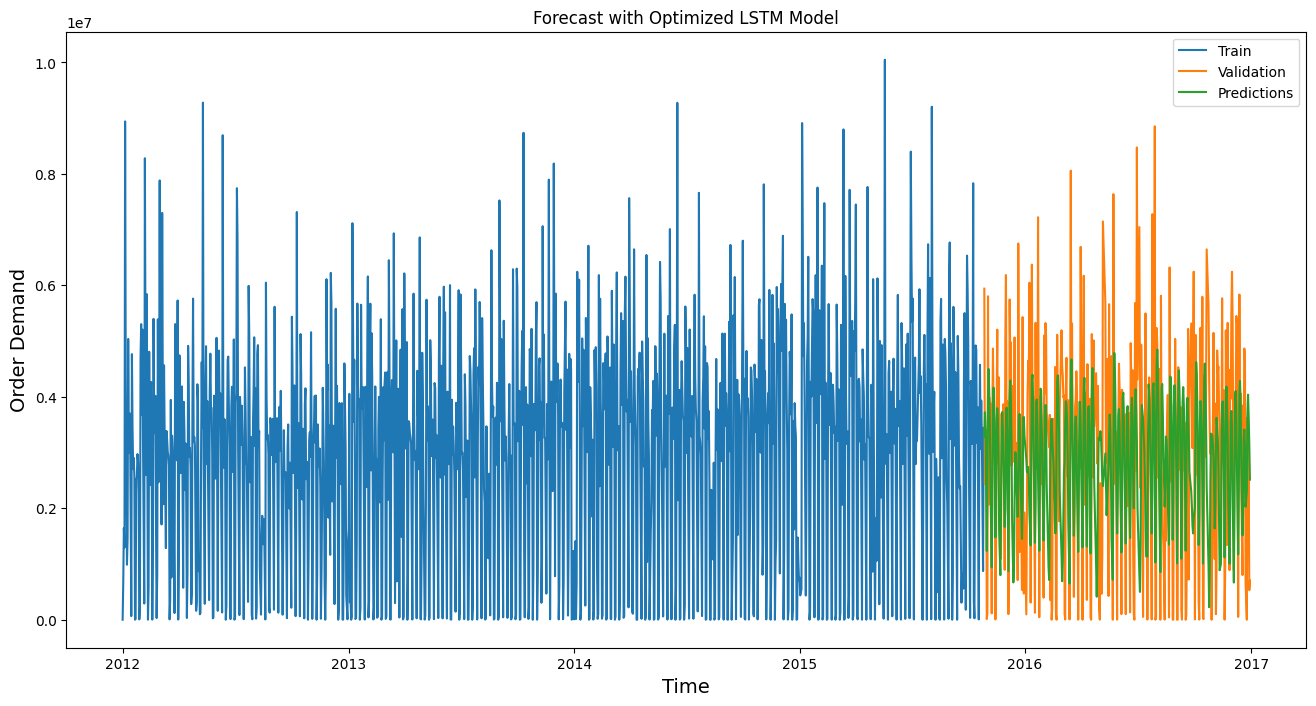

In [30]:
X_train, y_train, X_test, y_test, sc = ts_train_test(df_sum_origin,30)
my_LSTM_model, LSTM_prediction = LSTM_model(X_train, y_train, X_test, sc)
actual_pred_plot(df_sum_origin,LSTM_prediction)

In [31]:
# Metric
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_log_error

In [32]:
# Model Metric
def mase(training_series, testing_series, prediction_series):
    n = training_series.shape[0]
    d = np.abs(np.diff(training_series)).sum() / (n-1)
    
    errors = np.abs(testing_series - prediction_series)
    return errors.mean() / d

# Model Metric
def mape(actual, pred): 
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / (actual+1)))

In [33]:
def display_metrics(train_series, actual, pred):
    MASE = mase(np.array(train_series), np.array(actual), pred)
    MAPE = mape(actual, pred)
    RMSE = mean_squared_error(actual, pred)**0.5
    MAE = mean_absolute_error(actual,pred)
    RMSLE = mean_squared_log_error(actual, pred)**0.5
    
    print('------------------ Metric ------------------')
    print('MASE: \t', MASE)
    print('MAPE: \t', MAPE)
    print('RMSE: \t', RMSE)
    print('MAE: \t',  MAE)
    print('RMSLE: \t', RMSLE)

In [35]:
orderD = df_sum_origin.filter(['price'])
train = orderD[:1300]
valid = orderD[1300:]
valid["Predictions"] = LSTM_prediction

display_metrics(train["price"],valid['price'], valid['Predictions'])

------------------ Metric ------------------
MASE: 	 0.7542729747569834
MAPE: 	 28581.366997438632
RMSE: 	 1879588.258864325
MAE: 	 1504694.9847440945
RMSLE: 	 2.6569533794856586


C:\Users\junsuk\AppData\Local\Temp\ipykernel_15872\1298686713.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid["Predictions"] = LSTM_prediction
